In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer


# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

In [2]:
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv') 

# Contents
- [Cleaning Train Dataset](#Cleaning-Train-Dataset)
- [Cleaning Test Dataset](#Cleaning-Test-Dataset)
- [Cleaning Weather Dataset](#Cleaning-Weather-Dataset)
- [Cleaning Spray Dataset](#Cleaning-Spray-Dataset)

### Cleaning Train Dataset

In [3]:
train.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
# convert all to lower case
train.columns = [word.lower() for word in train.columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10506 non-null  object 
 1   address                 10506 non-null  object 
 2   species                 10506 non-null  object 
 3   block                   10506 non-null  int64  
 4   street                  10506 non-null  object 
 5   trap                    10506 non-null  object 
 6   addressnumberandstreet  10506 non-null  object 
 7   latitude                10506 non-null  float64
 8   longitude               10506 non-null  float64
 9   addressaccuracy         10506 non-null  int64  
 10  nummosquitos            10506 non-null  int64  
 11  wnvpresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


Check null

In [6]:
# no null values 
train.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
dtype: int64

In [7]:
# Converting Date column from object type to datetime type.

train['date'] = train['date'].map(lambda date: datetime.strptime(date, '%Y-%m-%d'))

Check for no. of mosquitoes per trap

<AxesSubplot:xlabel='date'>

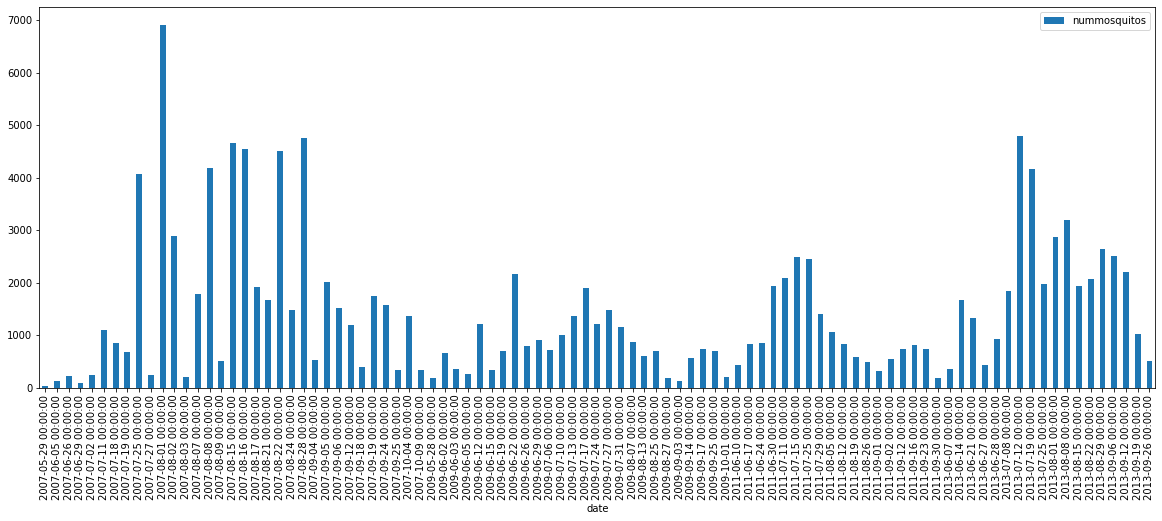

In [8]:
pd.pivot_table(train, values='nummosquitos', index=['date'], aggfunc=np.sum).plot.bar(figsize = (20,7))


In [9]:
def change_month(month):
    convert = month.to_pydatetime().month
    month_dict = {
        1: 'Jan',
        2: 'Feb',
        3: 'Mar',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: "Aug",
        9: 'Sept',
        10: 'Oct',
        11: 'Nov',
        12: 'Dec'
    }

    return month_dict[convert]

train['month_num'] = train['date'].apply(lambda x: x.to_pydatetime().month)
train['month'] = train['date'].apply(change_month)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Text(0.5, 0, 'Total number of mosquitos per month')

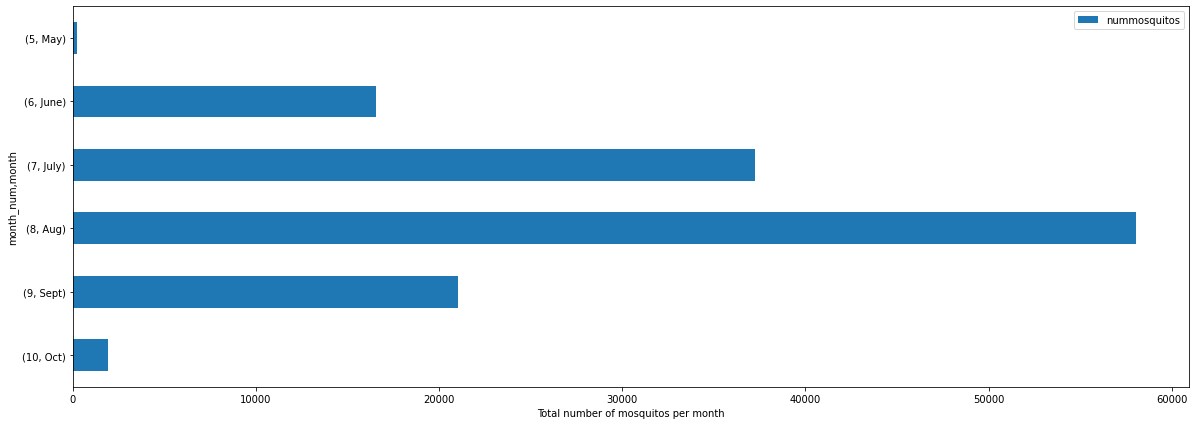

In [10]:
pd.pivot_table(train, values='nummosquitos', index=['month_num','month'], aggfunc=np.sum).sort_values(by ='month_num', ascending = False).plot.barh(figsize = (20,7))

plt.xlabel('Total number of mosquitos per month')
plt.xlabel('Total number of mosquitos per month')


There seem to be a cyclical trend across the years, particularly in August. Trend seems to be picking up from June to August. 

Data seems duplicated. Need to remove duplicated because of the nummosquitos limit to 50.

In [11]:
train.shape

(10506, 14)

In [12]:
# remove duplicates from train data
train.drop_duplicates(ignore_index=True, inplace = True)

In [13]:
train.shape

(9693, 14)

In [14]:
# Groupby species to check how many are present 

train.groupby('species')['wnvpresent'].sum()

species
CULEX ERRATICUS             0
CULEX PIPIENS             208
CULEX PIPIENS/RESTUANS    246
CULEX RESTUANS             49
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: wnvpresent, dtype: int64

In [15]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'month_num', 'month'],
      dtype='object')

<AxesSubplot:ylabel='trap'>

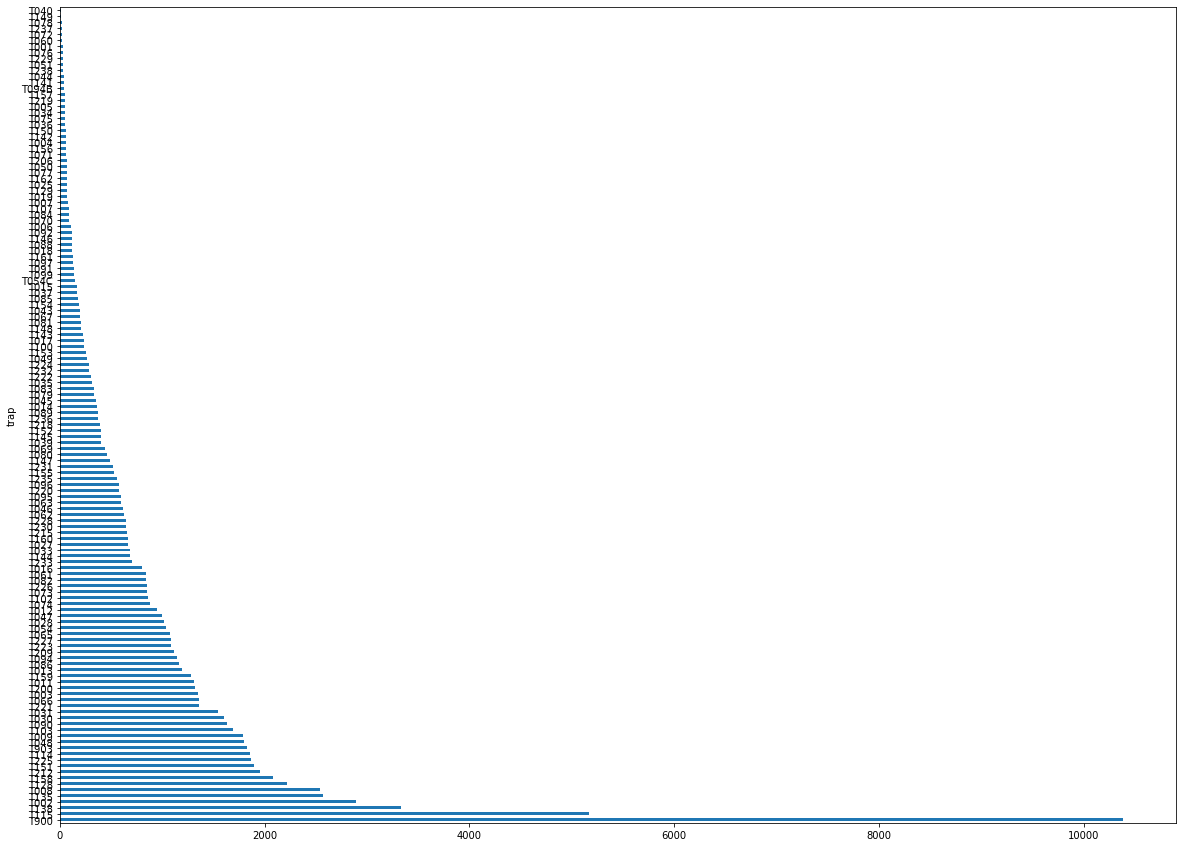

In [16]:
train.groupby(['trap']).sum().sort_values(by = 'nummosquitos', ascending = False)['nummosquitos'].plot.barh(figsize = (20,15))

3 out of the 7 groups of species are identified to have West Nile virus. Uniquely we have 2, mainly pipiens and restuans being prominent.  

### Cleaning Weather Dataset

In [17]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [18]:
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [19]:
# convert all to lower case
weather.columns = [word.lower() for word in weather.columns]

In [20]:
# convert date time 
weather['date'] = weather['date'].map(lambda date: datetime.strptime(date, '%Y-%m-%d'))

In [21]:
# create month column 
weather['month'] = weather['date'].apply(change_month)

In [22]:
weather.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'water1', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'month'],
      dtype='object')

In [23]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

TAVG is object 

In [24]:
print(f'Total rows for weather: {weather.shape[0]}\n')
for col in weather.columns:
    if 'M' in weather[col].unique().tolist():
        count = weather[col].value_counts()['M']
        print(f'Column {col} has {count} number of "M"');

Total rows for weather: 2944

Column tavg has 11 number of "M"
Column depart has 1472 number of "M"
Column wetbulb has 4 number of "M"
Column heat has 11 number of "M"
Column cool has 11 number of "M"
Column depth has 1472 number of "M"
Column water1 has 2944 number of "M"
Column snowfall has 1472 number of "M"
Column preciptotal has 2 number of "M"
Column stnpressure has 4 number of "M"
Column sealevel has 9 number of "M"
Column avgspeed has 3 number of "M"


In [25]:
# drop water1 rows since majority is M  
weather.drop(columns='water1', inplace = True)

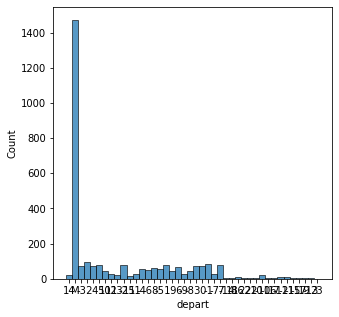

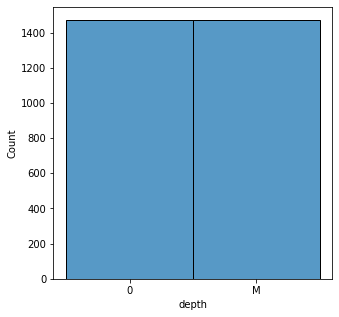

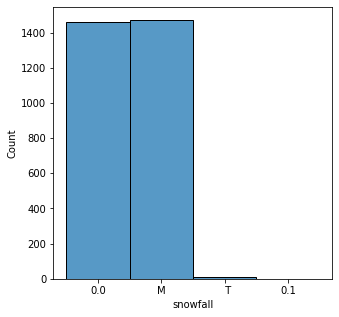

In [26]:
for col in ['depart','depth', 'snowfall']:
    plt.figure(figsize=(5,5))
    sns.histplot(x = col, data = weather)

Need to drop snowfall and depth since not much information to impute. 


In [27]:
# Dropping unnecessary columns.

cols_to_drop = ['depart', 'depth', 'snowfall']
weather.drop(columns=cols_to_drop, inplace=True)

In [28]:
print(f'Total rows for weather: {weather.shape[0]}\n')
for col in weather.columns:
    if 'M' in weather[col].unique().tolist():
        count = weather[col].value_counts()['M']
        print(f'Column {col} has {count} number of "M"');

Total rows for weather: 2944

Column tavg has 11 number of "M"
Column wetbulb has 4 number of "M"
Column heat has 11 number of "M"
Column cool has 11 number of "M"
Column preciptotal has 2 number of "M"
Column stnpressure has 4 number of "M"
Column sealevel has 9 number of "M"
Column avgspeed has 3 number of "M"


In [29]:
# Replacing 'T's and 'M's with 0s in some columns.

weather.preciptotal.replace(['  T','M'], 0, inplace=True)
weather.wetbulb.replace(['M'], 0, inplace=True)
weather.heat.replace(['M'], 0, inplace=True)
weather.cool.replace(['M'], 0, inplace=True)
weather.stnpressure.replace(['M'], 0, inplace=True)
weather.sealevel.replace(['M'], 0, inplace=True)
weather.avgspeed.replace(['M'], 0, inplace=True)

In [30]:
# Calculate Tavg using (Tmax + Tmin)/2 to deal with 'M's in Tavg.

weather['tavg'] = (weather.tmax + weather.tmin)/2

In [31]:
# Changing column dtypes from type object to type float.

weather.preciptotal = weather.preciptotal.astype(float)
weather.wetbulb = weather.wetbulb.astype(float)
weather.heat = weather.heat.astype(float)
weather.cool = weather.cool.astype(float)
weather.stnpressure = weather.stnpressure.astype(float)
weather.sealevel = weather.sealevel.astype(float)
weather.avgspeed = weather.avgspeed.astype(float)

In [32]:
weather.head()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,month
0,1,2007-05-01,83,50,66.5,51,56.0,0.0,2.0,0448,1849,,0.0,29.10,29.82,1.7,27,9.2,May
1,2,2007-05-01,84,52,68.0,51,57.0,0.0,3.0,-,-,,0.0,29.18,29.82,2.7,25,9.6,May
2,1,2007-05-02,59,42,50.5,42,47.0,14.0,0.0,0447,1850,BR,0.0,29.38,30.09,13.0,4,13.4,May
3,2,2007-05-02,60,43,51.5,42,47.0,13.0,0.0,-,-,BR HZ,0.0,29.44,30.08,13.3,2,13.4,May
4,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,0446,1851,,0.0,29.39,30.12,11.7,7,11.9,May


In [33]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   float64       
 5   dewpoint     2944 non-null   int64         
 6   wetbulb      2944 non-null   float64       
 7   heat         2944 non-null   float64       
 8   cool         2944 non-null   float64       
 9   sunrise      2944 non-null   object        
 10  sunset       2944 non-null   object        
 11  codesum      2944 non-null   object        
 12  preciptotal  2944 non-null   float64       
 13  stnpressure  2944 non-null   float64       
 14  sealevel     2944 non-null   float64       
 15  resultspeed  2944 non-null   float64       
 16  result

In [34]:
# Grouping values from station 1 & 2 by `dates``.
# We take mean for the values measured by Station 1 and 2

weather_data_com = weather.groupby('date').mean()

In [35]:
# drop station column 

weather_data_com.drop(columns = 'station', inplace = True)

In [36]:
weather_data_com.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
date,,,,,,,,,,,,,
2007-05-01,83.5,51.0,67.25,51.0,56.5,0.0,2.5,0.0,29.140,29.820,2.20,26.0,9.40
2007-05-02,59.5,42.5,51.00,42.0,47.0,13.5,0.0,0.0,29.410,30.085,13.15,3.0,13.40
2007-05-03,66.5,47.0,56.75,40.0,49.0,8.0,0.0,0.0,29.425,30.120,12.30,6.5,12.55
2007-05-04,72.0,50.0,61.00,41.5,50.0,3.5,0.0,0.0,29.335,30.045,10.25,7.5,10.60
2007-05-05,66.0,53.5,59.75,38.5,49.5,5.0,0.0,0.0,29.430,30.095,11.45,7.0,11.75


In [37]:
weather.sunrise.unique()

array(['0448', '-', '0447', '0446', '0444', '0443', '0442', '0441',
       '0439', '0438', '0437', '0436', '0435', '0434', '0433', '0432',
       '0431', '0430', '0429', '0428', '0427', '0426', '0425', '0424',
       '0423', '0422', '0421', '0420', '0419', '0418', '0417', '0416',
       '0440', '0445', '0449', '0450', '0451', '0452', '0453', '0454',
       '0455', '0456', '0457', '0458', '0459', '0500', '0501', '0502',
       '0503', '0504', '0505', '0506', '0508', '0509', '0510', '0511',
       '0512', '0513', '0514', '0515', '0516', '0517', '0518', '0519',
       '0520', '0521', '0522', '0523', '0524', '0525', '0526', '0527',
       '0528', '0529', '0530', '0531', '0532', '0533', '0535', '0536',
       '0537', '0538', '0539', '0540', '0541', '0542', '0543', '0544',
       '0545', '0546', '0547', '0548', '0549', '0550', '0552', '0553',
       '0554', '0555', '0556', '0557', '0558', '0559', '0600', '0602',
       '0603', '0604', '0605', '0606', '0607', '0608', '0610', '0611',
       '0

In [38]:
weather.sunset.unique()

array(['1849', '-', '1850', '1851', '1852', '1853', '1855', '1856',
       '1857', '1858', '1859', '1860', '1901', '1902', '1903', '1904',
       '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912',
       '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920',
       '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928',
       '1929', '1930', '1931', '1900', '1854', '1848', '1846', '1845',
       '1843', '1842', '1840', '1839', '1837', '1835', '1834', '1832',
       '1831', '1829', '1827', '1826', '1824', '1822', '1821', '1819',
       '1817', '1815', '1814', '1812', '1810', '1809', '1807', '1805',
       '1803', '1760', '1758', '1756', '1755', '1753', '1751', '1749',
       '1748', '1746', '1744', '1742', '1741', '1739', '1737', '1735',
       '1734', '1732', '1730', '1729', '1727', '1725', '1724', '1722',
       '1720', '1719', '1717', '1715', '1714', '1712', '1711', '1709',
       '1707', '1706', '1704', '1703', '1701', '1660', '1658', '1657',
       '1

Need to normalize 24h format to float 

In [39]:
# Define function to help convert 24h to float (0430 -->> 4.5)

def suntime_float(sun_time):
  
  # Getting the hour part of the time to convert to the whole number part in the float number.
  hours = sun_time // 100

  # Getting the minute part of the time to convert to the decimal part in the float number.
  minutes = (sun_time % 100) / 60

  return hours + minutes

merge with weather_data_com

In [40]:
# Creating series of sunrise and sunset times and converting them to dtype float.
sunrise_times = weather[weather['station']==1]['sunrise'].astype(float)
sunset_times = weather[weather['station']==1]['sunset'].astype(float)

# Mapping the above created function to convert 24h time values to floating point numbers.
weather_data_com['sunrise'] = list(sunrise_times.map(suntime_float))
weather_data_com['sunset'] = list(sunset_times.map(suntime_float))

Checking code sum should only have these based on Daily Table format given by Kaggle 

`FC` - Tornado

`FC` - Funnel Cloud

`TS` - Thunderstorm

`GR` - Hail

`RA` - Rain


In [41]:
weather['codesum'].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [42]:
# Replacing string of weather conditions given in the codesum column.

weather['codesum'] = weather['codesum'].str.replace("BCFG","BC FG")
weather['codesum'] = weather['codesum'].str.replace("MIFG","MI FG")
weather['codesum'] = weather['codesum'].str.replace("TSRA","TS RA")
weather['codesum'] = weather['codesum'].str.replace("VCFG","VC FG")
weather['codesum'] = weather['codesum'].str.replace("VCTS","VC TS")

In [43]:
# Defining a function to clean the weather conditions given in Codesum column.

def clean_codesum(string):
    return " ".join(set(" ".join(string).split(' ')))

In [44]:
weather.groupby('date')['codesum'].agg(clean_codesum)

date
2007-05-01            
2007-05-02       HZ BR
2007-05-03          HZ
2007-05-04          RA
2007-05-05            
                ...   
2014-10-27          RA
2014-10-28          RA
2014-10-29            
2014-10-30          RA
2014-10-31    SN RA BR
Name: codesum, Length: 1472, dtype: object

In [45]:
codesum_groupedby_date = weather.groupby('date')['codesum'].agg(clean_codesum)

Merged codesum by date. Now need to vectorize


In [46]:
# Applying CountVectorizer to create dummy columns of each individual weather condition.

cvec = CountVectorizer(analyzer='word', token_pattern=r'[\w\+]+')
code_sum_cvec = cvec.fit_transform(codesum_groupedby_date)
code_sum_df = pd.DataFrame(code_sum_cvec.toarray(),weather['date'].unique(), columns=cvec.get_feature_names_out())
code_sum_df = code_sum_df.reset_index().rename( columns = {'index': 'date'})
code_sum_df

,date,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2007-05-03,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2007-05-04,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2007-05-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1468,2014-10-28,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1469,2014-10-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1470,2014-10-30,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [47]:
# check shape 

code_sum_df.shape

(1472, 15)

In [48]:
weather_data_com.shape

(1472, 15)

In [49]:
weather_data_com.reset_index(inplace = True)

In [50]:
weather_data_com

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,sunrise,sunset
0,2007-05-01,83.5,51.0,67.25,51.0,56.5,0.0,2.5,0.000,29.140,29.820,2.20,26.0,9.40,4.800000,18.816667
1,2007-05-02,59.5,42.5,51.00,42.0,47.0,13.5,0.0,0.000,29.410,30.085,13.15,3.0,13.40,4.783333,18.833333
2,2007-05-03,66.5,47.0,56.75,40.0,49.0,8.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,4.766667,18.850000
3,2007-05-04,72.0,50.0,61.00,41.5,50.0,3.5,0.0,0.000,29.335,30.045,10.25,7.5,10.60,4.733333,18.866667
4,2007-05-05,66.0,53.5,59.75,38.5,49.5,5.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,4.716667,18.883333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.25,51.5,58.5,0.5,1.0,0.010,28.960,29.665,12.35,19.0,13.25,6.300000,16.883333
1468,2014-10-28,67.0,46.5,56.75,39.0,47.5,8.0,0.0,0.015,29.190,29.850,14.40,26.0,15.10,6.316667,16.850000
1469,2014-10-29,49.0,38.0,43.50,33.0,41.0,21.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,6.333333,16.833333
1470,2014-10-30,52.0,34.5,43.25,34.5,41.0,21.5,0.0,0.000,29.375,30.095,5.50,23.5,6.00,6.366667,16.816667


In [51]:
cleaned_weather_df = weather_data_com.merge(code_sum_df, on = 'date')
cleaned_weather_df

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,sunrise,sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-01,83.5,51.0,67.25,51.0,56.5,0.0,2.5,0.000,29.140,29.820,2.20,26.0,9.40,4.800000,18.816667,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,59.5,42.5,51.00,42.0,47.0,13.5,0.0,0.000,29.410,30.085,13.15,3.0,13.40,4.783333,18.833333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2007-05-03,66.5,47.0,56.75,40.0,49.0,8.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,4.766667,18.850000,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2007-05-04,72.0,50.0,61.00,41.5,50.0,3.5,0.0,0.000,29.335,30.045,10.25,7.5,10.60,4.733333,18.866667,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2007-05-05,66.0,53.5,59.75,38.5,49.5,5.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,4.716667,18.883333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.25,51.5,58.5,0.5,1.0,0.010,28.960,29.665,12.35,19.0,13.25,6.300000,16.883333,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1468,2014-10-28,67.0,46.5,56.75,39.0,47.5,8.0,0.0,0.015,29.190,29.850,14.40,26.0,15.10,6.316667,16.850000,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1469,2014-10-29,49.0,38.0,43.50,33.0,41.0,21.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,6.333333,16.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1470,2014-10-30,52.0,34.5,43.25,34.5,41.0,21.5,0.0,0.000,29.375,30.095,5.50,23.5,6.00,6.366667,16.816667,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Cleaning Spray Dataset

In [52]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [53]:
# convert all to lower case
spray.columns = [word.lower() for word in spray.columns]

In [54]:
spray.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

In [55]:
# Change date column to be datetime dtype
spray['date'] = pd.to_datetime(spray['date']).dt.date

In [56]:
spray['time'] = pd.to_datetime(spray['time'])

In [57]:
# spray.set_index('date' ,inplace = True)
# spray.sort_index(inplace=True)

In [58]:
for date in spray['date'].unique():
    print(date,'Earlist time:', spray[spray['date'] == date]['time'].min().time(),'Latest time:', spray[spray['date'] == date]['time'].max().time())

2011-08-29 Earlist time: 18:56:58 Latest time: 19:15:28
2011-09-07 Earlist time: 19:42:12 Latest time: 21:41:10
2013-07-17 Earlist time: 10:49:04 Latest time: 21:55:27
2013-07-25 Earlist time: 19:58:20 Latest time: 22:37:26
2013-08-08 Earlist time: 20:16:44 Latest time: 22:23:45
2013-08-15 Earlist time: 20:13:56 Latest time: 23:59:58
2013-08-16 Earlist time: 00:00:01 Latest time: 00:24:49
2013-08-22 Earlist time: 20:02:55 Latest time: 23:44:46
2013-08-29 Earlist time: 20:06:39 Latest time: 22:28:57
2013-09-05 Earlist time: 19:27:13 Latest time: 20:40:56


Time range for each of these days has many variations. will not be useful if merging with other dataset. hence need to remove column time. 


In [59]:
spray.drop(columns = 'time', inplace= True)

In [60]:
spray.isnull().sum()

date         0
latitude     0
longitude    0
dtype: int64

In [61]:
spray.shape

(14835, 3)

In [62]:
spray.drop_duplicates(subset = ['date', 'latitude', 'longitude'])

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858
...,...,...,...
14830,2013-09-05,42.006587,-87.812355
14831,2013-09-05,42.006192,-87.816015
14832,2013-09-05,42.006022,-87.817392
14833,2013-09-05,42.005453,-87.817423


### Cleaning Test Dataset

In [63]:
# convert all to lower case
test.columns = [word.lower() for word in test.columns]

In [64]:
# Change date column to be datetime dtype
test['date'] = pd.to_datetime(test['date'])

In [65]:
test.set_index('date' ,inplace = True)


In [66]:
test.sort_index(inplace=True)

In [67]:
# resample by month 'M'
test.isnull().sum()

id                        0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
dtype: int64

### Merging train and weather

In [68]:
train.shape

(9693, 14)

In [69]:
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,month_num,month
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,May
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,May
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,May
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,May
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,May


In [70]:
train.set_index('date', inplace = True)

In [80]:
test= train.groupby(['latitude', 'longitude','date']).sum()

test

block  addressaccuracy  nummosquitos  \
latitude  longitude  date                                               
41.644612 -87.604498 2007-08-01    164               10            11   
                     2007-08-02    246               15            27   
                     2007-08-07    164               10            44   
                     2007-08-15    164               10            25   
                     2007-08-22    164               10            12   
...                                ...              ...           ...   
42.017430 -87.687769 2011-06-10     75                8             2   
                     2011-06-17     75                8             2   
                     2011-06-30     75                8             1   
                     2011-07-11    150               16            27   
                     2011-07-15     75                8             1   

                                 wnvpresent  month_num  
latitude  longitude  date                               
41.644612 -87.604498 2007-08-01           0         16  
                     2007-08-02           0         24  
                     2007-08-07           0         16  
                     2007-08-15           0         16  
                     2007-08-22           1         16  
...                                     ...        ...  
42.017430 -87.687769 2011-06-10           0          6  
                     2011-06-17           0          6  
                     2011-06-30           0          6  
                     2011-07-11           0         14  
                     2011-07-15           0          7  

[4616 rows x 5 columns]

In [86]:
test.reset_index(inplace = True)

In [90]:
get_sum_nummosquitos = test.groupby(['latitude', 'longitude']).sum()

In [72]:
train.shape

(9693, 13)

In [73]:
merge_train_weather = train.merge(cleaned_weather_df, on = 'date', how = 'inner')

In [99]:
merge_train_weather.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'month_num', 'month', 'tmax', 'tmin',
       'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'sunrise', 'sunset', 'bc', 'br', 'dz', 'fg', 'fg+', 'fu', 'gr', 'hz',
       'mi', 'ra', 'sn', 'sq', 'ts', 'vc'],
      dtype='object')

In [100]:
drop_col = ['address', 'block', 'street', 'addressaccuracy','addressnumberandstreet']

In [101]:
merge_train_weather.drop(columns = drop_col, inplace = True)

In [105]:
merge_train_weather

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,month_num,month,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,sunrise,sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,5,May,88.0,62.5,75.25,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,4.350000,19.283333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,5,May,88.0,62.5,75.25,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,4.350000,19.283333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,5,May,88.0,62.5,75.25,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,4.350000,19.283333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,5,May,88.0,62.5,75.25,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,4.350000,19.283333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,5,May,88.0,62.5,75.25,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,4.350000,19.283333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9688,2013-09-26,CULEX PIPIENS/RESTUANS,T035,41.763733,-87.742302,6,1,9,Sept,75.0,52.5,63.75,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,5.716667,17.700000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9689,2013-09-26,CULEX PIPIENS/RESTUANS,T231,41.987280,-87.666066,5,0,9,Sept,75.0,52.5,63.75,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,5.716667,17.700000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9690,2013-09-26,CULEX PIPIENS/RESTUANS,T232,41.912563,-87.668055,1,0,9,Sept,75.0,52.5,63.75,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,5.716667,17.700000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9691,2013-09-26,CULEX PIPIENS/RESTUANS,T233,42.009876,-87.807277,5,0,9,Sept,75.0,52.5,63.75,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,5.716667,17.700000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
